In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# os.chdir('drive/MyDrive/RAVDESS/Scripts')

os.listdir('runstest')

In [ ]:
# writer1 = SummaryWriter('runstest/inception_emodb_train')
# writer2 = SummaryWriter('runstest/inception_emodb_val')
# writer1 = SummaryWriter('runstest/resnet_train')
# writer2 = SummaryWriter('runstest/resnet_val')
writer1 = SummaryWriter('runstest/googlenet_train')
writer2 = SummaryWriter('runstest/googlenet_val')

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
data_dir = "../MEL"
model_dir = "../Models25"
csv_dir = "../Speech_CSV_ravdess"

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(classes)

tensor([1, 7, 5, 3, 2, 5, 4, 6, 3, 2, 5, 2, 7, 1, 2, 7, 2, 2, 6, 3, 3, 4, 3, 7,
        0, 0, 7, 3, 1, 7, 7, 1])


In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

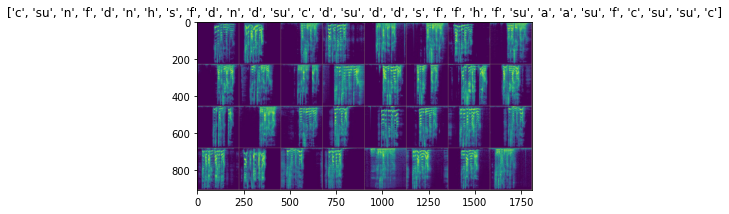

In [ ]:
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def plot(val_loss,train_loss,typ):
    plt.title("{} after epoch: {}".format(typ,len(train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel(typ)
    plt.plot(list(range(len(train_loss))),train_loss,color="r",label="Train "+typ)
    plt.plot(list(range(len(val_loss))),val_loss,color="b",label="Validation "+typ)
    plt.legend()
    plt.savefig(os.path.join(data_dir,typ+".png"))
    plt.close()

In [ ]:
val_loss_gph=[]
train_loss_gph=[]
val_acc_gph=[]
train_acc_gph=[]

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,model_name = "kaggle"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, d in enumerate(tqdm(dataloaders[phase])):
                inputs = d[0].to(device)
                labels = d[1].to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) #was (outputs,1) for non-inception and (outputs.data,1) for inception
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_gph.append(epoch_loss)
                train_acc_gph.append(epoch_acc)
                writer1.add_scalar('accuracy',
                            epoch_acc,
                            epoch)
            if phase == 'val':
                val_loss_gph.append(epoch_loss)
                val_acc_gph.append(epoch_acc)
                writer2.add_scalar('accuracy',
                            epoch_acc,
                            epoch)

            
            #plot(val_loss_gph,train_loss_gph, "Loss")
            #plot(val_acc_gph,train_acc_gph, "Accuracy")
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, '../Models25/GooglenetModel.pth')
                print('==>Model Saved')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#model = torch.load('../Models/inception.h5')
# model = models.inception_v3(pretrained=True)
model = models.googlenet(pretrained=True)
# model = models.resnet18(pretrained=True)
# model.aux_logits=False
model = model.cuda()
# model.eval()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
num_ftrs = model.fc.in_features

In [ ]:
print("Number of features: "+str(num_ftrs))
# Here the size of each output sample is set to 2.

Number of features: 1024


In [ ]:
model.fc = nn.Linear(num_ftrs, num_classes)
model.fc = model.fc.cuda() ## for vgg11
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
#  torch.cuda.empty_cache()

In [ ]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)

# model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25, model_name = "inception")
# model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25, model_name = "resnet")
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25, model_name = "googlenet")

Epoch 1/25
----------


100%|██████████| 108/108 [00:37<00:00,  2.91it/s]


train Loss: 1.0259 Acc: 0.6267


100%|██████████| 28/28 [00:04<00:00,  6.82it/s]


val Loss: 1.3333 Acc: 0.5690
==>Model Saved

Epoch 2/25
----------


100%|██████████| 108/108 [00:37<00:00,  2.92it/s]


train Loss: 0.4508 Acc: 0.8475


100%|██████████| 28/28 [00:04<00:00,  6.93it/s]


val Loss: 0.7567 Acc: 0.7310
==>Model Saved

Epoch 3/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.93it/s]


train Loss: 0.2595 Acc: 0.9122


100%|██████████| 28/28 [00:04<00:00,  6.94it/s]


val Loss: 0.5990 Acc: 0.7839
==>Model Saved

Epoch 4/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.2427 Acc: 0.9217


100%|██████████| 28/28 [00:04<00:00,  6.91it/s]


val Loss: 0.4702 Acc: 0.8391
==>Model Saved

Epoch 5/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.94it/s]


train Loss: 0.1052 Acc: 0.9667


100%|██████████| 28/28 [00:03<00:00,  7.17it/s]


val Loss: 0.2878 Acc: 0.9011
==>Model Saved

Epoch 6/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.1071 Acc: 0.9687


100%|██████████| 28/28 [00:03<00:00,  7.00it/s]


val Loss: 0.3744 Acc: 0.8851

Epoch 7/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.1280 Acc: 0.9565


100%|██████████| 28/28 [00:04<00:00,  6.90it/s]


val Loss: 0.4615 Acc: 0.8598

Epoch 8/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.1215 Acc: 0.9594


100%|██████████| 28/28 [00:04<00:00,  6.96it/s]


val Loss: 0.3661 Acc: 0.8828

Epoch 9/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.1239 Acc: 0.9586


100%|██████████| 28/28 [00:04<00:00,  6.93it/s]


val Loss: 0.2125 Acc: 0.9276
==>Model Saved

Epoch 10/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.0672 Acc: 0.9777


100%|██████████| 28/28 [00:04<00:00,  6.95it/s]


val Loss: 0.1097 Acc: 0.9667
==>Model Saved

Epoch 11/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.0147 Acc: 0.9959


100%|██████████| 28/28 [00:04<00:00,  6.99it/s]


val Loss: 0.0453 Acc: 0.9839
==>Model Saved

Epoch 12/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.0072 Acc: 0.9986


100%|██████████| 28/28 [00:04<00:00,  6.96it/s]


val Loss: 0.0359 Acc: 0.9885
==>Model Saved

Epoch 13/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.0056 Acc: 0.9994


100%|██████████| 28/28 [00:04<00:00,  7.00it/s]


val Loss: 0.0370 Acc: 0.9874

Epoch 14/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.0043 Acc: 0.9994


100%|██████████| 28/28 [00:04<00:00,  6.92it/s]


val Loss: 0.0295 Acc: 0.9908
==>Model Saved

Epoch 15/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.0027 Acc: 1.0000


100%|██████████| 28/28 [00:04<00:00,  6.99it/s]


val Loss: 0.0296 Acc: 0.9920
==>Model Saved

Epoch 16/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.94it/s]


train Loss: 0.0024 Acc: 1.0000


100%|██████████| 28/28 [00:03<00:00,  7.10it/s]


val Loss: 0.0246 Acc: 0.9943
==>Model Saved

Epoch 17/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.0029 Acc: 0.9997


100%|██████████| 28/28 [00:04<00:00,  6.87it/s]


val Loss: 0.0232 Acc: 0.9943
==>Model Saved

Epoch 18/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.94it/s]


train Loss: 0.0027 Acc: 0.9997


100%|██████████| 28/28 [00:04<00:00,  6.83it/s]


val Loss: 0.0218 Acc: 0.9954
==>Model Saved

Epoch 19/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.95it/s]


train Loss: 0.0016 Acc: 1.0000


100%|██████████| 28/28 [00:03<00:00,  7.00it/s]


val Loss: 0.0209 Acc: 0.9943

Epoch 20/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.94it/s]


train Loss: 0.0018 Acc: 1.0000


100%|██████████| 28/28 [00:04<00:00,  6.92it/s]


val Loss: 0.0246 Acc: 0.9943

Epoch 21/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.93it/s]


train Loss: 0.0016 Acc: 1.0000


100%|██████████| 28/28 [00:04<00:00,  6.86it/s]


val Loss: 0.0210 Acc: 0.9943

Epoch 22/25
----------


100%|██████████| 108/108 [00:37<00:00,  2.91it/s]


train Loss: 0.0016 Acc: 1.0000


100%|██████████| 28/28 [00:04<00:00,  6.92it/s]


val Loss: 0.0206 Acc: 0.9966
==>Model Saved

Epoch 23/25
----------


100%|██████████| 108/108 [00:37<00:00,  2.92it/s]


train Loss: 0.0023 Acc: 0.9994


100%|██████████| 28/28 [00:04<00:00,  6.88it/s]


val Loss: 0.0243 Acc: 0.9943

Epoch 24/25
----------


100%|██████████| 108/108 [00:37<00:00,  2.92it/s]


train Loss: 0.0022 Acc: 1.0000


100%|██████████| 28/28 [00:04<00:00,  6.92it/s]


val Loss: 0.0191 Acc: 0.9954

Epoch 25/25
----------


100%|██████████| 108/108 [00:36<00:00,  2.92it/s]


train Loss: 0.0014 Acc: 1.0000


100%|██████████| 28/28 [00:04<00:00,  6.84it/s]

val Loss: 0.0217 Acc: 0.9943

Training complete in 17m 8s
Best val Acc: 0.996552


In [ ]:
# checkpoint = torch.load('../Models25/InceptionModel.pth')
# checkpoint = torch.load('../Models25/ResnetModel.pth')
checkpoint = torch.load('../Models25/GooglenetModel.pth')
# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')
# load trained optimizer state_dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('Previously trained optimizer state_dict loaded...')
# load the criterion
criterion = checkpoint['loss']
print('Trained model loss function loaded...')

Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Trained model loss function loaded...


In [ ]:
# Getting Proba distribution
print("\nGetting the Probability Distribution")
testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)


Getting the Probability Distribution


In [ ]:
model=model.eval()
correct = 0
total = 0
import csv
import numpy as np
# f = open("../Speech_CSV_ravdess_test/inceptionEMODB.csv",'w+',newline = '')
# f = open("../Speech_CSV_ravdess_test/ResnetModel.csv",'w+',newline = '')
f = open("../Speech_CSV_ravdess_test/GoogleNetModel.csv",'w+',newline = '')

writer_vgg = csv.writer(f)

confusion_matrix = torch.zeros(num_classes, num_classes)
num_classes

8

In [ ]:
with torch.no_grad():
      num = 0
      temp_array = np.zeros((len(testloader),num_classes))
      for data in testloader:
          images, labels = data
          #labels=labels.cuda()
          outputs = model(images.cuda())
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels.cuda()).sum().item()
          prob = torch.nn.functional.softmax(outputs, dim=1)
          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])
          num+=1
          for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
print("Accuracy = ",100*correct/total)

Accuracy =  99.65517241379311


In [ ]:
confusion_matrix

tensor([[116.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 116.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 116.,   0.,   0.,   0.,   0.,   0.],
        [  2.,   0.,   0., 114.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., 116.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  58.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   1., 115.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 116.]])

In [ ]:
for i in range(len(testloader)):
  writer_vgg.writerow(temp_array[i].tolist())

f.close()

Accuracy =  95.41547277936962